# Spacecraft file: attitude and position

The spacecraft is always moving and changing orientations. The attitude --i.e. orientation-- vs. time is handled by the SpacecraftFile class. This allows us to transform from spacecraft coordinates to inertial coordinate --e.g. galactics coordinates.

<div class="alert alert-block alert-info">
<b>Note:</b> In future versions, the SpacecraftFile class will handle the spacecraft location --i.e. latitude, longitude, and altitude-- in addition to its attitude. This will allow us to know where the Earth is located in the field of view, which we are currently ignoring for simplicity.</div>

## Dependencies

In [3]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from mhealpy import HealpixMap
import pandas as pd
from astropy.time import Time
from pathlib import Path
from scoords import Attitude, SpacecraftFrame
from pathlib import Path
import shutil
import os

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.util import fetch_wasabi_file

## File downloads

You can skip this step if you already downloaded the files. Make sure that paths point to the right files

In [4]:
data_dir = Path("") # Current directory by default. Modify if you can want a different path

In [6]:
ori_path = data_dir/"20280301_3_month_with_orbital_info.ori"
response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.h5"

In [7]:
# download orientation file ~684.38 MB
if not ori_path.exists():
    fetch_wasabi_file("COSI-SMEX/DC2/Data/Orientation/20280301_3_month_with_orbital_info.ori", ori_path)

# download response file ~839.62 MB
if not response_path.exists():
    
    fetch_wasabi_file("COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.zip", zipped_response_path)

    # unzip the response file
    shutil.unpack_archive(zipped_response_path, extract_dir = data_dir)

    # move the extracted response to the data_dir
    
    # delete the zipped response to save space
    os.remove(zipped_response_path)

## Orientation file format and loading

The attitude os the spacecraft is specified by the galactic coordinates that the x and z axes of the spacecraft are pointing to. The y-axis pointing can be deduced from this information (right-handed system convention).

The following diagram shows the relation between the spacecraft --i.e. local-- and galactic --i.e. inertial-- reference frames.

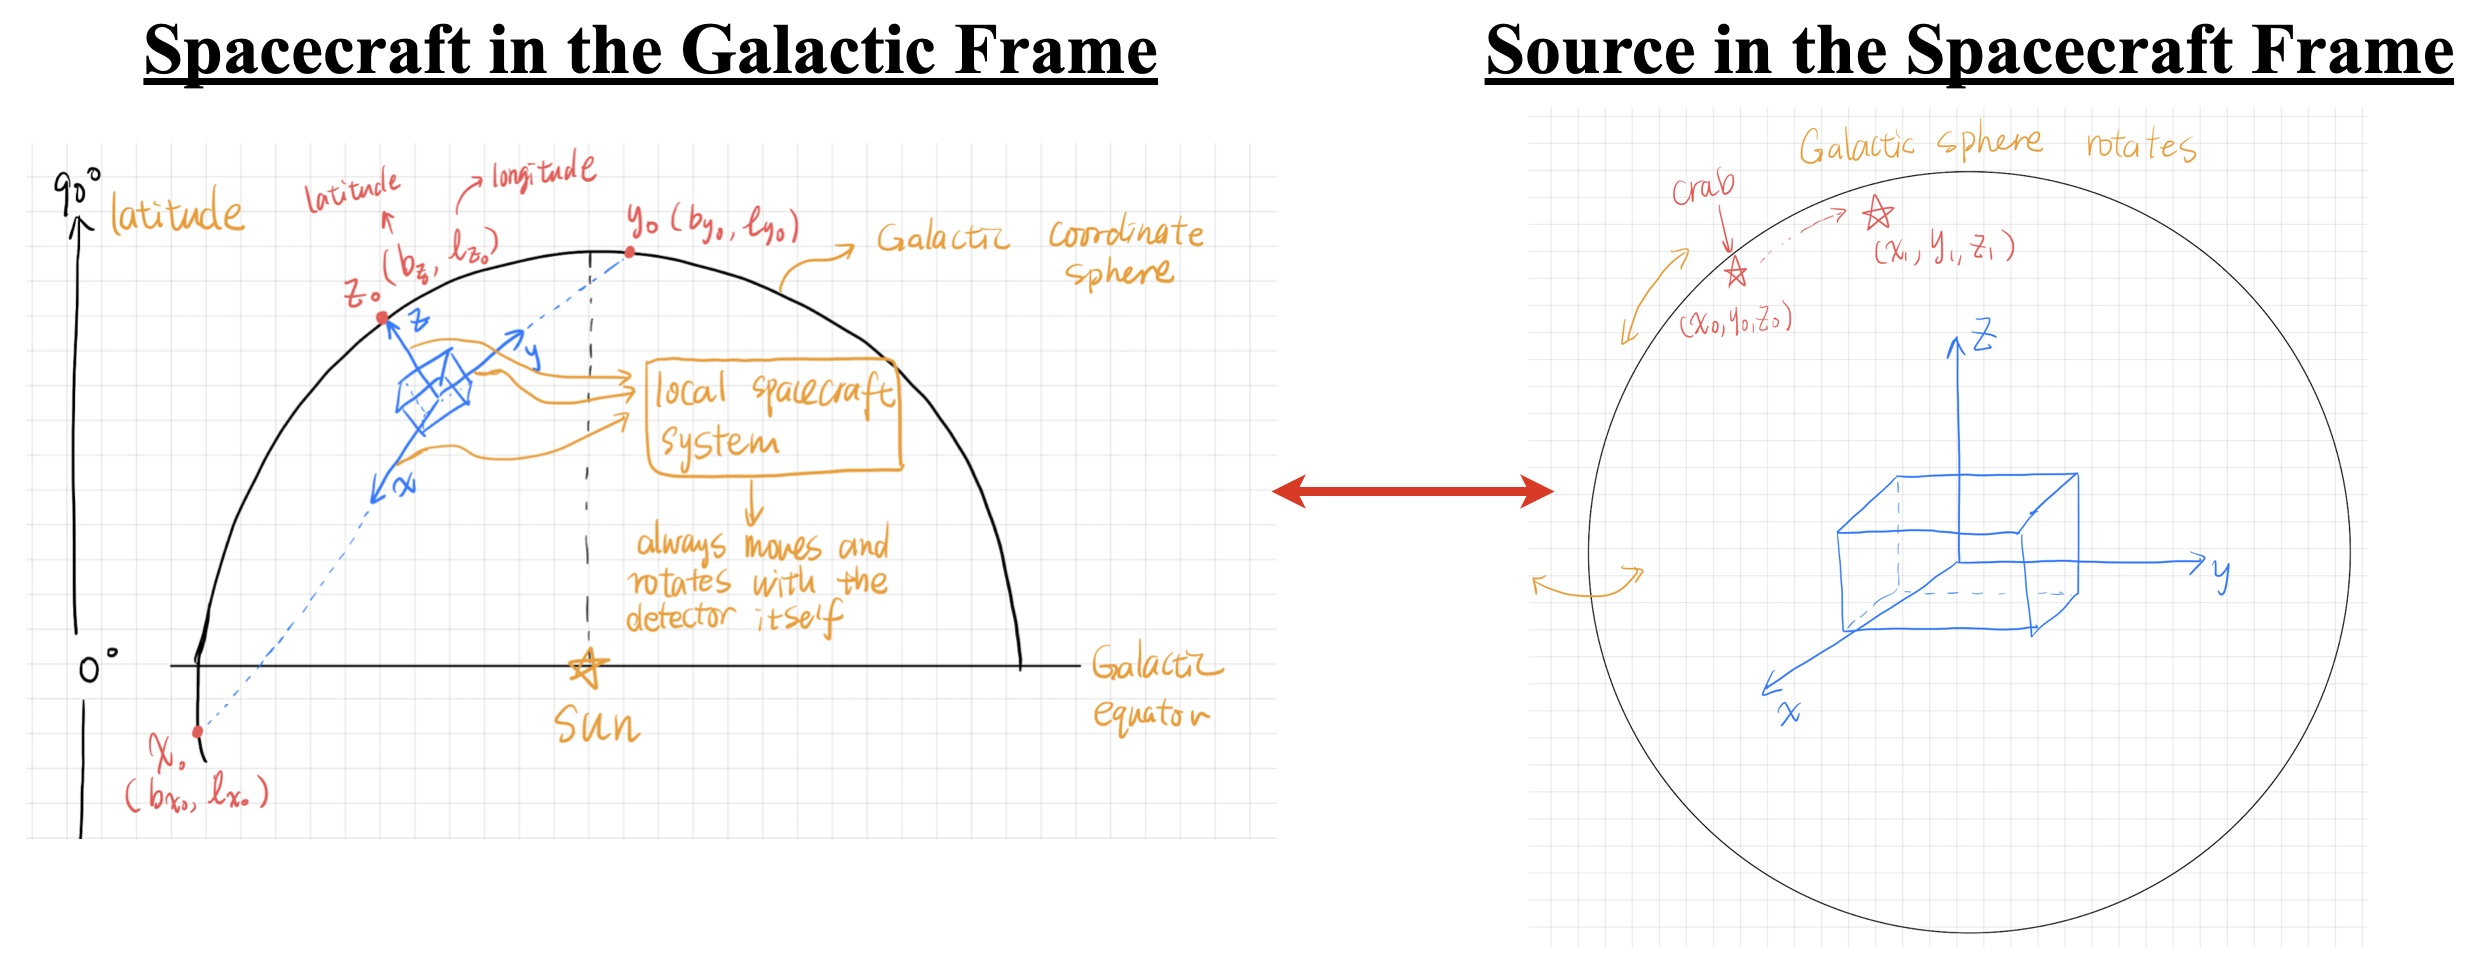

Currently, this information is stored in a text file with a filename ending in ".ori", a format inherited from MEGALib. Each line contains the keyword "OG", followd by: time stamp (GPS seconds), x-axis galactic latitude (deg), x-axis galactic longitude (deg), z-axis galactic latitude (deg), z-axis galactic longitude (deg). 

In [4]:
with open(ori_path) as f:
    for i in range(10):
        print(f.readline())

#Type OrientationsGalactic 

OG 1835487300.0 68.44034002307066 44.61117227945379 -21.559659976929343 44.61117227945379

OG 1835487301.0 68.38920658776064 44.642124027021296 -21.610793412239364 44.642124027021296

OG 1835487302.0 68.3380787943012 44.67309722321497 -21.661921205698793 44.67309722321497

OG 1835487303.0 68.28695666554313 44.70409195030112 -21.713043334456863 44.70409195030112

OG 1835487304.0 68.2358402243372 44.73510829054615 -21.764159775662804 44.73510829054615

OG 1835487305.0 68.18472949353415 44.76614632621641 -21.81527050646584 44.76614632621641

OG 1835487306.0 68.13362449598479 44.79720613957824 -21.8663755040152 44.79720613957824

OG 1835487307.0 68.08252525453989 44.82828781289802 -21.91747474546011 44.82828781289801

OG 1835487308.0 68.0314317920502 44.859391428442066 -21.968568207949804 44.859391428442066



<div class="alert alert-block alert-info">
<b>Note:</b> The orientation (.ori) file format will change in the future, from a text file to a FITS file. However, the file contents and the capabilities of the SpacecraftFile class will be the same.</div>

You don't have to remember the internal format though, just load it using the SpacecraftFile class:

In [5]:
ori = SpacecraftFile.parse_from_file(ori_path)

# Let's use only 1 hr in this example
ori = ori.source_interval(ori.get_time()[0], ori.get_time()[0] + 1*u.hr)


WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"


WARNING ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



You can plot the pointings to see how the zenith changes over the observation. In this example, we'll plot only 1 hr:


WARNING ErfaWarning: ERFA function "utctai" yielded 3601 of "dubious year (Note 3)"



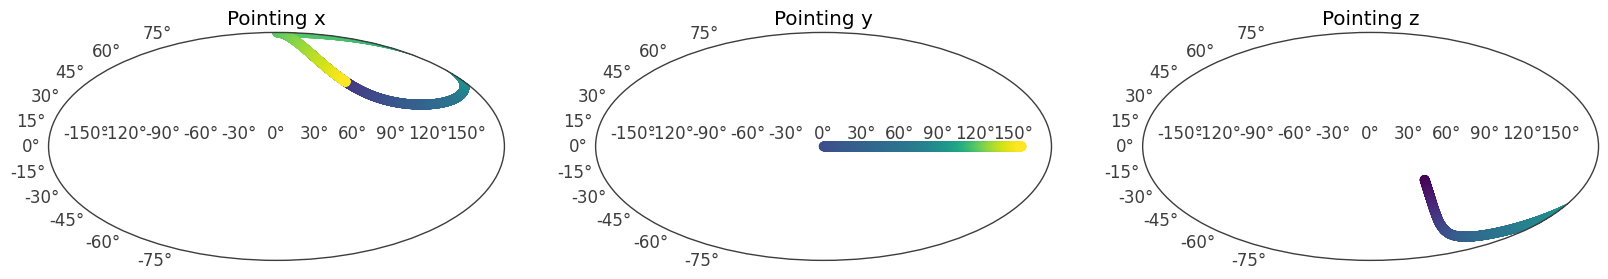

In [6]:
import matplotlib

# Get a time range interval
ori = ori.source_interval(ori.get_time()[0], ori.get_time()[0] + 1*u.hr)

# Plot
fig,ax = plt.subplots(ncols = 3, figsize = [20,5], subplot_kw = {'projection':'mollweide'})

# Use color to represent time
cmap = get_cmap('viridis')
time_sec = (ori.get_time() - ori.get_time()[0]).to_value(u.s)
time_color = cmap(time_sec/np.max(time_sec))

# Plot the galactic coordinate of each SC axis
for n,(label,pointing) in enumerate(zip(['x','y','z'], ori.get_attitude().as_axes())):

    ax[n].scatter(pointing.l.rad, pointing.b.rad, color = time_color)
    ax[n].set_title(f"Pointing {label}")

## Calculate the source movement in the SC frame

This converts a fixed coordinate in the galactic frame to the coordinate in the SC frame as a function of time:

In [7]:
# define the target coordinates
target_coord = SkyCoord(71.334998265514, 03.0668346317, unit = "deg", frame = "galactic")

# get the target path in the Spacecraft frame 
target_in_sc_frame = ori.get_target_in_sc_frame(target_name = "CygX1", target_coord = target_coord)

Now converting to the Spacecraft frame...
Conversion completed!


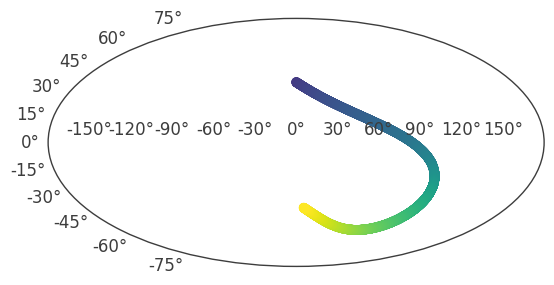

In [8]:
fig,ax = plt.subplots(subplot_kw = {'projection':'mollweide'})

ax.scatter(target_in_sc_frame.lon.rad, target_in_sc_frame.lat.rad, color = time_color)

## The dwell time map

Since the response of the instrument is a function of the local coordinates, we need to calculate the movement of the source in the spacecraft frame. This is achieved with the help of a "dwell time map", which contains the amount of time a given source spent in a particular location of the COSI field of view. This is then convolved with the instrument response to get the point source response. 

In [9]:
%%time
dwell_time_map = ori.get_dwell_map(response = response_path, src_path = target_in_sc_frame)

CPU times: user 7.68 ms, sys: 3.33 ms, total: 11 ms
Wall time: 10.3 ms


Plot the dwell time map in detector coordinates. The top is the boresight of the instrument. Note that in this plot the longitude increases to the left.

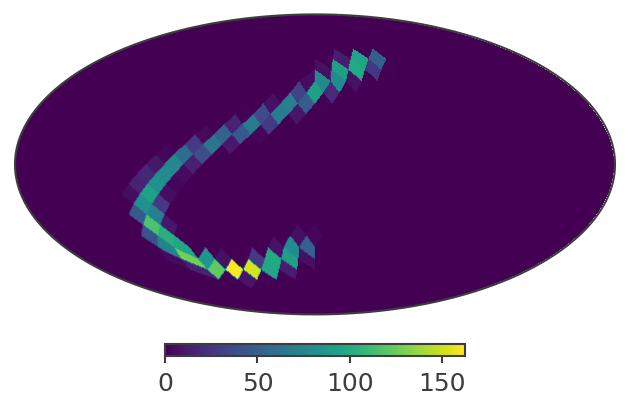

In [10]:
plot, ax = dwell_time_map.plot(coord = SpacecraftFrame(attitude = Attitude.identity()));

The dwell time map sums up to the total observed time:

In [11]:
np.sum(dwell_time_map)

<Quantity 3600. s>

## The scatt map

As the spacecraft rotates, a fixed source in the sky is seen by the detector from multiple direction. Convolving the dweel time map with the instrument response, without binning it simultenously in time, can wash out the signal. Since the spacecraft can have the same orientation multiple times, we avoid performing the same rotation multiple times by creating a histogram that keeps track of the attitude information. This is the "spacecraft attitude map" ---a.k.a scatt mapp--- which is a 4D matrix that contain the amount of time that the `x` and `y` SC axes were pointing at a given location in inertial coordinates -e.g. galactic.

In [12]:
# It's recommended that the scatt map pixel size be finer than the response, in order to mitigate error
scatt_map = ori.get_scatt_map(nside = 16, coordsys = 'galactic')


WARNING ErfaWarning: ERFA function "utctai" yielded 3601 of "dubious year (Note 3)"



This is a how the 2D projections looks like

(<MollviewSubplot: >, <matplotlib.image.AxesImage at 0x1324a9fd0>)

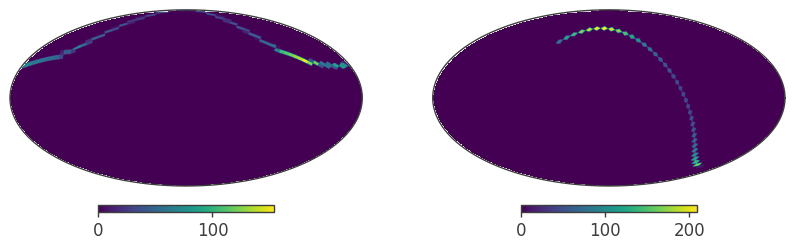

In [13]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(ncols = 2, subplot_kw = {'projection':'mollview'}, figsize = [10,5])

scatt_map.project('x').plot(axes[0])
scatt_map.project('y').plot(axes[1])